# Data Overview
_Author : Benjamin Ternot_

## I. Importing Libraries and Basic functions

In [1]:
import datetime
import gzip
import os
import shutil
from typing import Optional

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd


In [2]:
# Modifier les couleurs des textes et des axes en fonction du thème de Jupyter
DARK_BG = True

if DARK_BG:
    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'
    plt.rcParams['axes.titlecolor'] = 'white'
else:
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.labelcolor'] = 'black'
    plt.rcParams['xtick.color'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'

In [3]:
def format_duration(duration):
    td = datetime.timedelta(seconds=duration)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    microseconds = td.microseconds
    seconds += microseconds / 1000000

    parts = []
    if td.days > 0:
        parts.append(f'{td.days}d')
    if hours > 0:
        parts.append(f'{hours}h')
    if minutes > 0:
        parts.append(f'{minutes}min')
    if seconds > 1:
        parts.append(f'{seconds:.2f}s')
    elif not parts:
        parts.append(f'{microseconds/1000:.2f}ms')

    return ' '.join(parts)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', rotation=0, ha='right')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    print(f'Categorization Accuracy : {np.trace(cm)/np.sum(cm):.2%}')
    return np.trace(cm)/np.sum(cm)

## II. Data Overview

In [5]:
class DataLoader:
    def __init__(self, root_folder: str):
        """
        Initialize the DataLoader with a root folder.

        Parameters:
        root_folder (str): The root directory where data is stored.
        """
        self.root_folder = root_folder
        self.data = {}

    def extract_gz(self, file_path: str) -> str:
        """
        Extract a .gz file.

        Parameters:
        file_path (str): The path to the .gz file.

        Returns:
        str: The path to the extracted file.
        """
        if file_path.endswith('.gz'):
            output_path = file_path[:-3]  # Remove the .gz extension
            with gzip.open(file_path, 'rb') as f_in:
                with open(output_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            return output_path
        return file_path

    def read_metadata(self, file_path: str) -> dict:
        """
        Read metadata from a file.

        Parameters:
        file_path (str): The path to the metadata file.

        Returns:
        dict: A dictionary containing the metadata.
        """
        metadata = {}
        with open(file_path, 'r') as file:
            for line in file:
                if ':' in line:
                    key, value = line.split(':', 1)
                    key = key.strip()
                    value = value.strip()
                    if value.isdigit():
                        metadata[key] = int(value)
                    else:
                        try:
                            metadata[key] = float(value)
                        except ValueError:
                            metadata[key] = value
        return metadata

    def load_data(self, sub_path: str, name: Optional[str]=None, store: Optional[bool]=False) -> dict:
        """
        Load data from a subpath and optionally store it.

        Parameters:
        sub_path (str): The subpath to load data from.
        name (str, optional): The name to store the data under. Defaults to None.
        store (bool, optional): Whether to store the data. Defaults to False.

        Returns:
        dict: A dictionary containing the loaded data.
        """
        folder_path = os.path.join(self.root_folder, sub_path)
        ids = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
        data = {}

        for id_subject in ids:
            metadata_path = os.path.join(folder_path, f"{id_subject}/Info.cfg")
            metadata = self.read_metadata(metadata_path)

            image_data = {}
            for image_type in ['ED', 'ES']:
                for image_suffix in ['', '_gt']:
                    image_path = os.path.join(
                        folder_path,
                        f"{id_subject}/{id_subject}_frame{metadata[image_type]:02}{image_suffix}.nii.gz"
                    )
                    extracted_image_path = self.extract_gz(image_path)
                    image_data[f"{image_type}{image_suffix}"] = nib.load(extracted_image_path).get_fdata()
            data[id_subject] = {"image_data": {k: v for k, v in image_data.items()},
                                "height": metadata["Height"], "weight": metadata["Weight"],
                                "group": metadata["Group"],
                                "nb_frames": metadata["NbFrame"],
                                }

        if store:
            key = name if name else sub_path
            self.data[key] = data

        return data

    def reset_data(self) -> list[str]:
        """
        Reset the data dictionary.

        Returns:
        list[str]: A list of keys that were in the data dictionary.
        """
        keys = list(self.data.keys())
        self.data.clear()
        return keys

    def delete_data(self, key: str) -> dict:
        """
        Delete a specific key from the data dictionary.

        Parameters:
        key (str): The key to delete.

        Returns:
        dict: The value associated with the deleted key, or None if the key was not found.
        """
        return self.data.pop(key, None)


In [6]:
# Define the root data folder
root_data_folder = "./database"

# Create a DataLoader instance
data_loader = DataLoader(root_data_folder)

# Define the sub path to the folders containing the data
data_sub_folders = {
    "train": "training",
    "test": "testing",
}

# Define the mapping from group labels to diagnostic classes
group_map = {
    "NOR": "Healthy control",
    "MINF": "Myocardial infarction",
    "DCM": "Dilated cardiomyopathy",
    "HCM": "Hypertrophic cardiomyopathy",
    "RV": "Abnormal right ventricle"
}

In [7]:
# Load the data
for key, sub_folder in data_sub_folders.items():
    data_loader.load_data(sub_folder, name=key, store=True)


In [8]:
class DataDisplayer:
    def __init__(self, data_loader: DataLoader):
        self.data_loader = data_loader
        self.data_df = self.create_dataframe()

    def create_dataframe(self) -> pd.DataFrame:
        data = self.data_loader.data
        records = []
        for data_name, examples in data.items():
            for id_example, example_data in examples.items():
                records.append({
                    'data_name': data_name,
                    'group': example_data['group'],
                    'id': id_example
                })
        return pd.DataFrame(records)

    def filter(self, data_name: Optional[str] = None, groups: Optional[list] = None, ids: Optional[list] = None) -> pd.DataFrame:
        df = self.data_df
        if data_name:
            df = df[df['data_name'] == data_name]
        if groups:
            df = df[df['group'].isin(groups)]
        if ids:
            df = df[df['id'].isin(ids)]
        return df

    def display_examples(self, data_name: Optional[str] = None, groups: Optional[list] = None, ids: Optional[list] = None, sort_by: Optional[tuple] = None, nb_examples: Optional[int] = None, per_combination: bool = False, format_sep: Optional[tuple[str]] = None, format_categories: Optional[tuple[str]] = None) -> None:
        df = self.filter(data_name, groups, ids)

        if nb_examples is not None:
            if per_combination:
                if sort_by[-1] == 'id':
                    df = df.groupby(list(sort_by[:-1])).sample(nb_examples).sort_values(list(sort_by))
                else :
                    df = df.groupby(list(sort_by)).sample(nb_examples).sort_values(list(sort_by))
            else:
                df = df.sample(nb_examples).sort_values(list(sort_by))

        current_sort_values = [None] * len(sort_by)
        indent = ""
        for _, row in df.iterrows():
            if sort_by is not None and format_sep is not None:
                for i, sort_key in enumerate(sort_by):
                    if row[sort_key] != current_sort_values[i]:
                        current_sort_values[i] = row[sort_key]
                        indent = "\t" * i
                        separator = format_sep[i]
                        print(f"{indent}{separator}")
                        if sort_key == 'group':
                            print(indent + format_categories[i].format(group_map[current_sort_values[i]]), end='')
                        else:
                            print(indent + format_categories[i].format(current_sort_values[i]), end='')
            self.print_metadata(row['data_name'], row['id'], indent + "\t")
            self.display_images(row['data_name'], row['id'])

    def print_metadata(self, data_name: str, id_example: str, indentation: str) -> None:
        data = self.data_loader.data[data_name]
        metadata = {
            "ID": id_example,
            "height": f"{data[id_example]['height']:.1f}cm",
            "weight": f"{data[id_example]['weight']:.1f}kg",
            "group": data[id_example]['group'],
            "nb_frames": data[id_example]['nb_frames']
        }
        print(indentation + "ID: {ID}, height: {height}, weight: {weight}, group: {group}, nb_frames: {nb_frames}".format(**metadata))

    def display_images(self, data_name: str, id_example: str) -> None:
        data = self.data_loader.data[data_name]
        fig, axs = plt.subplots(1, 4)
        fig.set_size_inches(10, 10)
        for i, im_type in enumerate(['ED', 'ES', 'ED_gt', 'ES_gt']):
            axs[i].imshow(data[id_example]['image_data'][im_type][:, :, 0], cmap='gray')
            axs[i].set_title(f"{im_type}")
        plt.show()

##########################################################################################
test data :
	------------------------------------------------------------
	Dilated cardiomyopathy :
		
					ID: patient101, height: 169.0cm, weight: 79.0kg, group: DCM, nb_frames: 30


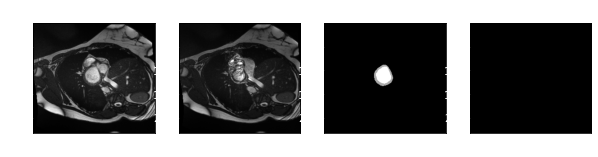

		
					ID: patient133, height: 185.0cm, weight: 121.0kg, group: DCM, nb_frames: 14


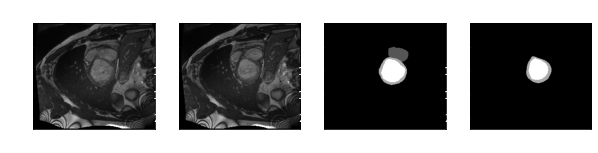

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :
		
					ID: patient104, height: 180.0cm, weight: 74.0kg, group: HCM, nb_frames: 30


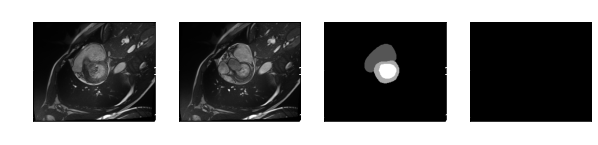

		
					ID: patient138, height: 174.0cm, weight: 90.0kg, group: HCM, nb_frames: 30


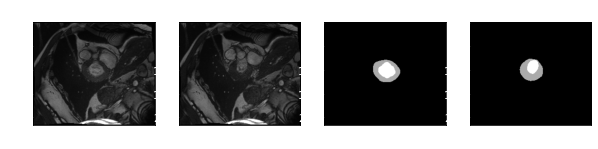

	------------------------------------------------------------
	Myocardial infarction :
		
					ID: patient137, height: 170.0cm, weight: 68.0kg, group: MINF, nb_frames: 30


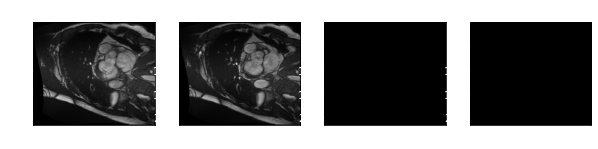

		
					ID: patient145, height: 171.0cm, weight: 80.0kg, group: MINF, nb_frames: 30


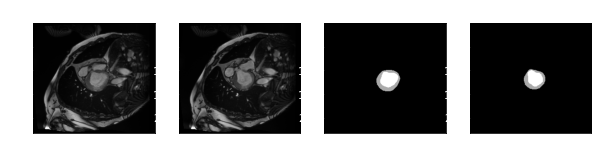

	------------------------------------------------------------
	Healthy control :
		
					ID: patient110, height: 167.0cm, weight: 116.0kg, group: NOR, nb_frames: 30


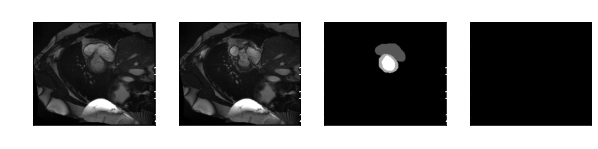

		
					ID: patient150, height: 158.0cm, weight: 56.0kg, group: NOR, nb_frames: 30


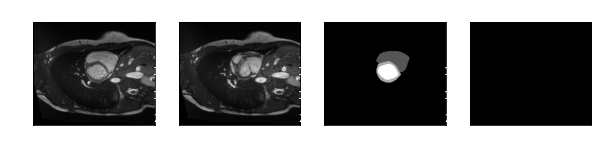

	------------------------------------------------------------
	Abnormal right ventricle :
		
					ID: patient129, height: 183.0cm, weight: 75.0kg, group: RV, nb_frames: 16


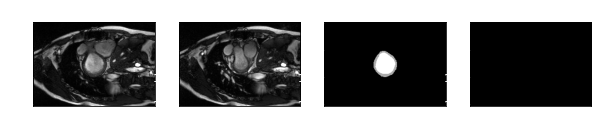

		
					ID: patient140, height: 165.0cm, weight: 68.0kg, group: RV, nb_frames: 15


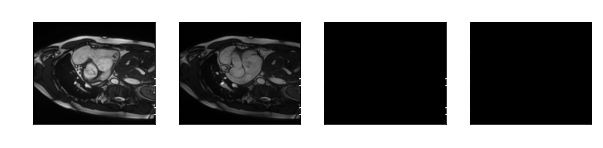

##########################################################################################
train data :
	------------------------------------------------------------
	Dilated cardiomyopathy :
		
					ID: patient018, height: 161.0cm, weight: 79.0kg, group: DCM, nb_frames: 13


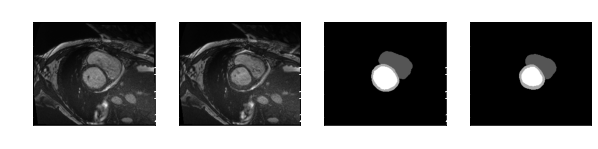

		
					ID: patient019, height: 191.0cm, weight: 97.0kg, group: DCM, nb_frames: 30


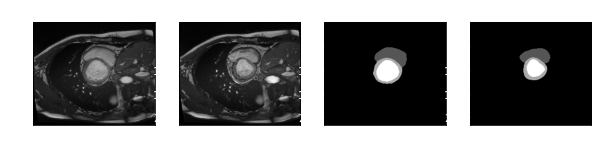

	------------------------------------------------------------
	Hypertrophic cardiomyopathy :
		
					ID: patient024, height: 175.0cm, weight: 85.0kg, group: HCM, nb_frames: 28


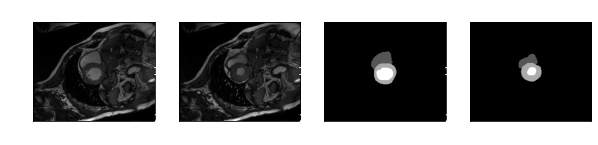

		
					ID: patient027, height: 158.0cm, weight: 60.0kg, group: HCM, nb_frames: 30


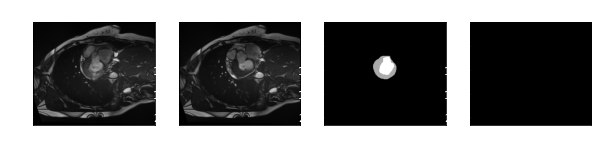

	------------------------------------------------------------
	Myocardial infarction :
		
					ID: patient051, height: 170.0cm, weight: 91.0kg, group: MINF, nb_frames: 30


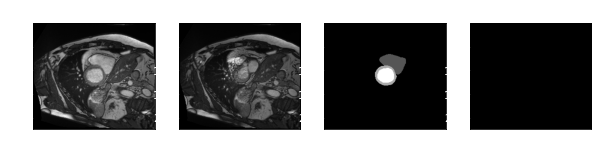

		
					ID: patient057, height: 175.0cm, weight: 80.0kg, group: MINF, nb_frames: 25


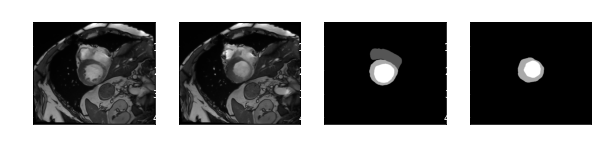

	------------------------------------------------------------
	Healthy control :
		
					ID: patient062, height: 172.0cm, weight: 74.0kg, group: NOR, nb_frames: 30


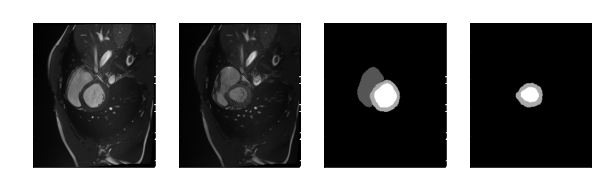

		
					ID: patient075, height: 179.0cm, weight: 93.0kg, group: NOR, nb_frames: 14


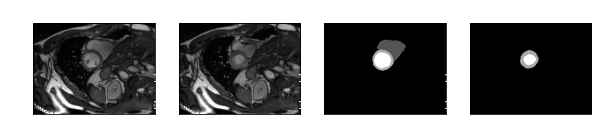

	------------------------------------------------------------
	Abnormal right ventricle :
		
					ID: patient081, height: 177.0cm, weight: 70.0kg, group: RV, nb_frames: 16


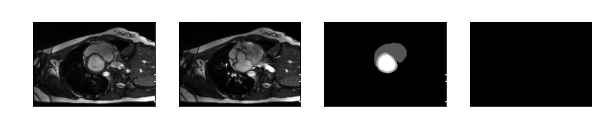

		
					ID: patient093, height: 165.0cm, weight: 65.0kg, group: RV, nb_frames: 30


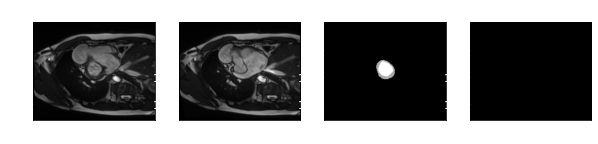

In [9]:
# Initialize the DataDisplayer with the DataLoader instance
data_displayer = DataDisplayer(data_loader)

# Display some examples
data_displayer.display_examples(nb_examples=2, per_combination=True, sort_by=('data_name', 'group', 'id'), format_sep=('#' * 90, '-' * 60, ''), format_categories=('{} data :\n', '{} :\n', ''))